In [72]:

import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from skimage.transform import resize
import pandas as pd
import pyarrow.parquet as pq

class BigEarthNetVegetationDataset(Dataset):
    def __init__(self, root_dir, metadata_parquet_path, required_bands=None,
                 max_samples_per_class=None, filter_cloud=True):
        """
        root_dir: BigEarthNet-S2 root (contains many tile folders)
        metadata_parquet_path: path to metadata.parquet
        required_bands: list of band suffixes, e.g. ['_B04.tif','_B03.tif',...]
        """
        self.root_dir = root_dir
        self.samples = []

        if required_bands is None:
            # Default: RGB + red-edge + NIR + SWIR
            required_bands = [
                '_B04.tif', '_B03.tif', '_B02.tif',  # RGB
                '_B05.tif', '_B06.tif', '_B07.tif', '_B8A.tif',  # Red-edge
                '_B08.tif',  # NIR
                '_B11.tif', '_B12.tif'  # SWIR
            ]

        # Load metadata parquet
        table = pq.read_table(metadata_parquet_path)
        df = table.to_pandas()

        # Filter cloudy or snowy patches if needed
        if filter_cloud:
            if 'contains_cloud_or_shadow' in df.columns:
                df = df[df['contains_cloud_or_shadow'] == False]
            if 'contains_seasonal_snow' in df.columns:
                df = df[df['contains_seasonal_snow'] == False]

        # Forest label set
        forest_labels = set(['Agro-forestry areas', 'Arable land', 'Broad-leaved forest',
         'Complex cultivation patterns', 'Coniferous forest', 
         'Land principally occupied by agriculture, with significant areas of natural vegetation',
          'Mixed forest', 'Moors, heathland and sclerophyllous vegetation',
           'Natural grassland and sparsely vegetated areas',
         'Pastures', 'Permanent crops', 'Transitional woodland, shrub'])

        # Binary label column
        df['binary_label'] = df['labels'].apply(
            lambda labels: 1.0 if set(labels) & forest_labels else 0.0
        )

        # Optional: limit samples per class
        if max_samples_per_class is not None:
            pos = df[df['binary_label'] == 1.0].sample(n=max_samples_per_class, random_state=42)
            neg = df[df['binary_label'] == 0.0].sample(n=max_samples_per_class, random_state=42)
            df = pd.concat([pos, neg]).reset_index(drop=True)

        # Iterate rows and load patches
        for _, row in df.iterrows():
            patch_id = row['patch_id']
            binary_label = float(row['binary_label'])

            found_patch_path = None
            for tile_folder in os.listdir(root_dir):
                tile_path = os.path.join(root_dir, tile_folder)
                candidate = os.path.join(tile_path, patch_id)
                if os.path.isdir(candidate):
                    if all(os.path.exists(os.path.join(candidate, patch_id + b)) for b in required_bands):
                        found_patch_path = candidate
                        break

            if not found_patch_path:
                continue  # Skip if not found or missing bands

            chans = []
            target_shape = None  # Will be set from first band
            try:
                for b in required_bands:
                    path = os.path.join(found_patch_path, patch_id + b)
                    with rasterio.open(path) as src:
                        arr = src.read(1).astype(np.float32)

                        # Set target shape from first band
                        if target_shape is None:
                            target_shape = arr.shape

                        # Resize if needed
                        if arr.shape != target_shape:
                            arr = resize(arr, target_shape, mode='reflect', anti_aliasing=True)

                        # Scale and clean
                        arr /= 10000.0
                        arr = np.nan_to_num(np.clip(arr, 0.0, 1.0))
                        chans.append(arr)

                # Compute NDVI & NDMI
                nir = chans[required_bands.index('_B08.tif')]
                red = chans[required_bands.index('_B04.tif')]
                swir = chans[required_bands.index('_B11.tif')] if '_B11.tif' in required_bands else None

                ndvi = (nir - red) / (nir + red + 1e-6)
                ndmi = (nir - swir) / (nir + swir + 1e-6) if swir is not None else np.zeros_like(ndvi)

                chans.append(ndvi)
                chans.append(ndmi)

                stacked = np.stack(chans, axis=0)  # Shape: C x H x W
                self.samples.append((stacked, binary_label))

            except Exception as e:
                print(f"Skipping {patch_id} due to {e}")
                continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        tensor = torch.tensor(image, dtype=torch.float32)

        # Resize to fixed size for model
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)

        return tensor, torch.tensor(label, dtype=torch.float32)

In [73]:
import torch.nn as nn
import torch

class SimpleCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # use adaptive pooling so FC receives fixed-size features regardless of input size
        self.adapt = nn.AdaptiveAvgPool2d((4,4))  # outputs [B, 64, 4, 4]
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 1)  # logits

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.adapt(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # raw logits (no sigmoid)

In [74]:
from torch.utils.data import DataLoader, random_split

def train_model(dataset_path, metadata_parquet, required_bands, num_epochs=10, batch_size=32, max_samples_per_class=None):
    # create dataset
    ds = BigEarthNetVegetationDataset(dataset_path, metadata_parquet_path=metadata_parquet,
                                      required_bands=required_bands, max_samples_per_class=max_samples_per_class)
    if len(ds) == 0:
        raise RuntimeError("No samples found in dataset. Check paths and required_bands.")
    # dynamic channels
    sample = ds[0][0]  # tensor CxHxW
    in_channels = sample.shape[0]

    train_size = int(0.8 * len(ds))
    val_size = len(ds) - train_size
    train_ds, val_ds = random_split(ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=min(batch_size, max(1, len(val_ds))), shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleCNN(in_channels).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)  # logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / max(1, len(train_loader))
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}  AvgLoss: {avg_loss:.4f}")

    return model, train_loader, val_loader, loss_history

def evaluate_model(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).squeeze(1)
            preds = (probs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    if total == 0:
        print("No validation samples.")
        return None
    acc = correct / total
    print(f"Validation Accuracy: {acc*100:.2f}% ({correct}/{total})")
    return acc

In [ ]:
required = ['_B04.tif','_B03.tif','_B02.tif','_B05.tif','_B06.tif','_B07.tif','_B8A.tif','_B08.tif','_B11.tif','_B12.tif']
model, train_loader, val_loader, loss_history = train_model(
    dataset_path=r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2",
    metadata_parquet=r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet",
    required_bands=required,
    num_epochs=15,
    batch_size=16,
    max_samples_per_class=5000  # small for quick test, increase later
)
evaluate_model(model, val_loader)

In [69]:
torch.save(model.state_dict(), 'forest_detector_model.pth')

In [14]:
import torch
import numpy as np
import rasterio
from skimage.transform import resize
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

def predict(model, image_path, required_bands, device='cpu', visualize=True):
    """
    Predicts from .npy, .tif, or image files, keeping only the required channels for the model.
    - required_bands: list of band suffixes used in training
    """

    chans = []
    target_shape = None

    # --- Case 1: NPY file ---
    if image_path.endswith('.npy'):
        arr = np.load(image_path)  # shape: [H, W, C]
        arr = arr.astype(np.float32)

        # Select only the bands you need (example: Sentinel-2 band numbers mapping)
        # Map your required_bands to npy indices if you know them
        band_mapping = {
            '_B02.tif': 1,  # Blue
            '_B03.tif': 2,  # Green
            '_B04.tif': 3,  # Red
            '_B05.tif': 4,
            '_B06.tif': 5,
            '_B07.tif': 6,
            '_B8A.tif': 7,
            '_B08.tif': 8,  # NIR
            '_B11.tif': 11,
            '_B12.tif': 12
        }

        for b in required_bands:
            idx = band_mapping[b]
            chans.append(arr[:, :, idx] / 10000.0)

        # NDVI + NDMI
        nir = chans[required_bands.index('_B08.tif')]
        red = chans[required_bands.index('_B04.tif')]
        swir = chans[required_bands.index('_B11.tif')]
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndmi = (nir - swir) / (nir + swir + 1e-6)

        chans.append(ndvi)
        chans.append(ndmi)

    # --- Case 2: TIF file ---
    elif image_path.endswith('.tif') or image_path.endswith('.tiff'):
            band_index_map = {
             '_B02.tif': 2,
             '_B03.tif': 3,
             '_B04.tif': 4,
             '_B05.tif': 5,
             '_B06.tif': 6,
             '_B07.tif': 7,
             '_B8A.tif': 8,  # 8A is band index 8 in most stacked TIFs if stored in wavelength order
             '_B08.tif': 8,  # sometimes NIR is also 8
             '_B11.tif': 11,
             '_B12.tif': 12
            }

            with rasterio.open(image_path) as src:
                for b in required_bands:
                    if b not in band_index_map:
                        raise ValueError(f"Unknown band name: {b}")
                    band_num = band_index_map[b]
                    arr = src.read(band_num).astype(np.float32)
                    if target_shape is None:
                        target_shape = arr.shape
                    if arr.shape != target_shape:
                        arr = resize(arr, target_shape, mode='reflect', anti_aliasing=True)
                    chans.append(arr / 10000.0)

            nir = chans[required_bands.index('_B08.tif')]
            red = chans[required_bands.index('_B04.tif')]
            swir = chans[required_bands.index('_B11.tif')]
            ndvi = (nir - red) / (nir + red + 1e-6)
            ndmi = (nir - swir) / (nir + swir + 1e-6)
            chans.append(ndvi)
            chans.append(ndmi)

    # --- Case 3: RGB image ---
    elif image_path.endswith('.png') or image_path.endswith('.jpg'):
        from PIL import Image
        img = Image.open(image_path).convert('RGB')
        img = np.array(img).astype(np.float32) / 255.0
        red, green, blue = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        ndvi = np.zeros_like(red)
        ndmi = np.zeros_like(red)
        chans = [red, green, blue] + [np.zeros_like(red)] * (len(required_bands) - 3) + [ndvi, ndmi]

    else:
        raise ValueError("Unsupported file type.")

    # --- Stack & preprocess ---
    arr = np.stack(chans, axis=0)  # C x H x W
    tensor = torch.tensor(arr, dtype=torch.float32).unsqueeze(0)
    tensor = F.interpolate(tensor, size=(64, 64), mode='bilinear', align_corners=False)
    tensor = tensor.to(device)

    # --- Prediction ---
    model.eval()
    with torch.no_grad():
        prob = model(tensor).item()
        label = "VEGETATION" if prob > 0.5 else "NO_VEGETATION"

    # --- Visualization ---
    if visualize:
        rgb_vis = np.stack([
            chans[required_bands.index('_B04.tif')] if '_B04.tif' in required_bands else chans[0],
            chans[required_bands.index('_B03.tif')] if '_B03.tif' in required_bands else chans[1],
            chans[required_bands.index('_B02.tif')] if '_B02.tif' in required_bands else chans[2]
        ], axis=-1)
        rgb_vis = np.clip(rgb_vis, 0, 1)
        plt.imshow(rgb_vis)
        plt.title(f"Prediction: {label}", fontsize=14, color='green' if label == "VEGETATION" else 'red')
        plt.axis('off')
        plt.show()

    return {'probability_forest': prob, 'predicted_label': label}

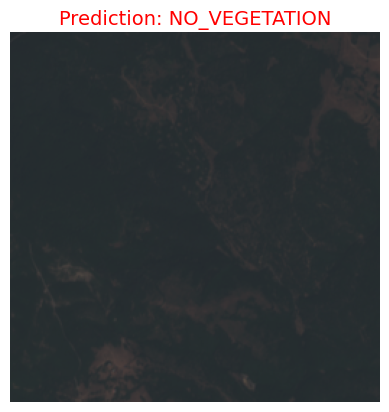

{'probability_forest': -4.00137996673584, 'predicted_label': 'NO_VEGETATION'}


In [64]:
required_bands = [
    '_B04.tif','_B03.tif','_B02.tif',
    '_B05.tif','_B06.tif','_B07.tif','_B8A.tif',
    '_B08.tif',
    '_B11.tif','_B12.tif'
]

testFile_path = r"C:\Users\mayer\Работен плот\final forest detector\greece_tile_(0, 256).npy"  # either folder with bands or stacked .tif
result = predict(model, testFile_path, required_bands, device='cpu')
print(result)